# Price stock tendency prediction pipeline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
def compute_MA(df, price_column, n=10):
    return df[price_column].rolling(n).mean()

In [3]:
def shift_values(df, column):
    shifted_column = df[column]
    shifted_column = shifted_column.shift(periods=-1)    
    return shifted_column

In [4]:
def pipeline_preprocessing(path, price_column, thresh_diff=0.5, verbose=False):
    df = get_data(path)
    keep_columns = ['Date', price_column, 'Volume']
    df = df.loc[:, keep_columns]
    
    df['Difference'] = compute_price_difference(df, price_column=price_column)
    df['PercentageDiff'] = compute_percentage_diff(df)
    df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','stay', 'higher'], thresh_diff=THRESH_DIFF)
    
    if verbose:
        value_counts = df.Tendency.value_counts().to_dict()
        for value, count in value_counts.items():
            print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
            
    df['MA'] = compute_MA(df, price_column)
    df['MA_diff'] = compute_MA(df, price_column, n=20) - compute_MA(df, price_column, n=10)
    df['RSI'] = compute_RSI(df, n=10, price_column=price_column, diff_column='Difference')
    df['Next'] = shift_values(df, column='Tendency')
    df = df.dropna()
    return df

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 15}, 
               'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 100}, 
               'SVM': {'gamma': 'auto'}, 
               'LR': {'penalty': 'l2', 'C': 1.0}
              }

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

TRAIN_RATIO = 0.7

def pipeline_ML(df, data_columns, y_column='Next', use_class_weights=True):
    dataset = df.copy()
    dataset = df.loc[:, data_columns]
    
    X = dataset.loc[:, dataset.columns != y_column]
    Y = dataset[y_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, train_size=TRAIN_RATIO, random_state=42)
    print(f"{len(X_train)} samples for training, {len(X_test)} for testing.")
    if use_class_weights:
        class_weights = compute_class_weight('balanced', np.unique(Y), Y)
        # formuse_class_weights=s dict
        class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}
    else:
        class_weights=None
        


    clf_dict = {}

    clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
    clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
    clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
    clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)
    
    print("Training...")

    for clf_label, clf in clf_dict.items():
        clf.fit(X_train, Y_train)

    print("Training done.")
    
    return clf_dict, (X_train, X_test, Y_train, Y_test)

### Evaluation

In [7]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

def evaluate(clf_dict, dataset_splits, experiment_label=''):
    X_train, X_test, Y_train, Y_test = dataset_splits
    for clf_label, clf in clf_dict.items():
        with mlflow.start_run(run_name=f"{clf_label} {experiment_label}"):
            Y_pred = clf.predict(X_test)

            accuracy = accuracy_score(Y_pred, Y_test)
            f1 = f1_score(Y_pred, Y_test, average='weighted')



            for param, val in best_params[clf_label].items():
                mlflow.log_param(param, val)
            mlflow.log_metric('acc', accuracy)
            mlflow.log_metric('f1', f1)
            mlflow.sklearn.log_model(clf, "sklearn model")

        print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
        plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

23235 samples for training, 9959 for testing.
Training...


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['higher' 'lower' 'stay'], y=20       lower
21        stay
22       lower
23      higher
24        stay
         ...  
3520      stay
3521      stay
3522     lower
3523    higher
3524     lower
Name: Next, Length: 33194, dtype: category
Categories (3, object): ['lower' < 'stay' < 'higher'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Training done.
[DTree] Accuracy : 0.39, F1 : 0.41
[RandomForest] Accuracy : 0.39, F1 : 0.44
[SVM] Accuracy : 0.35, F1 : 0.52
[LR] Accuracy : 0.35, F1 : 0.52


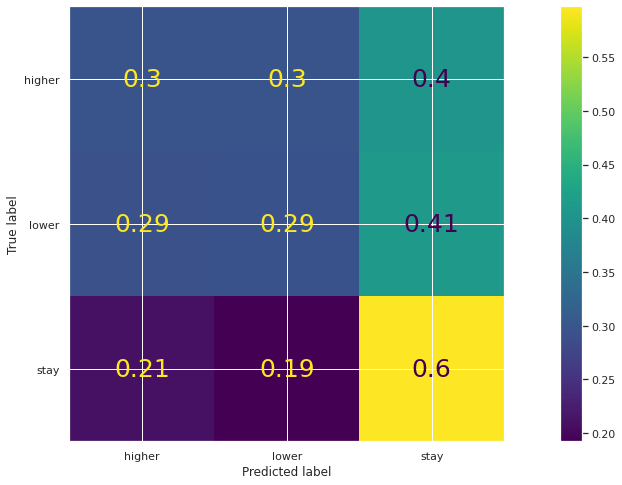

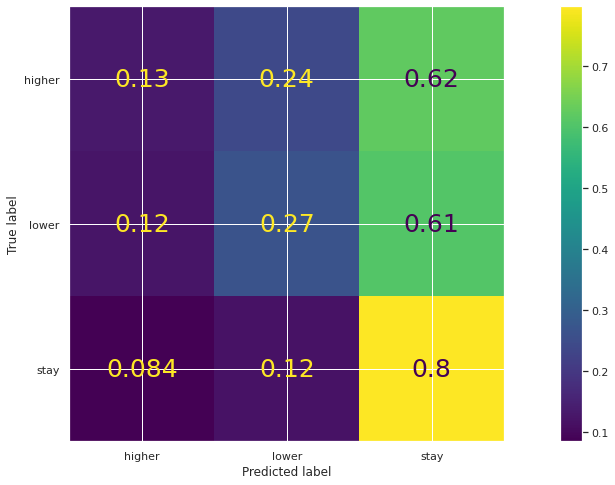

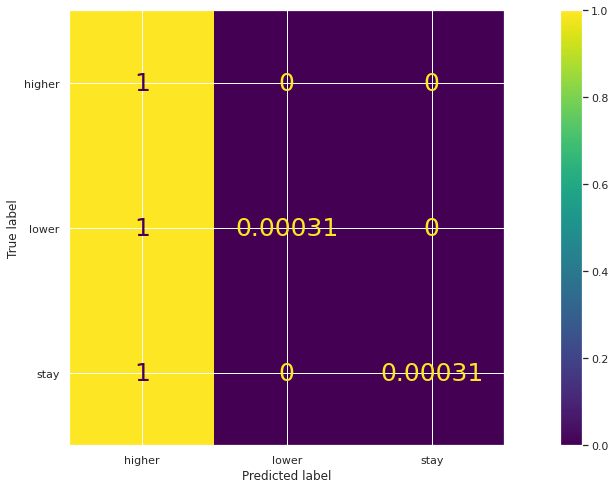

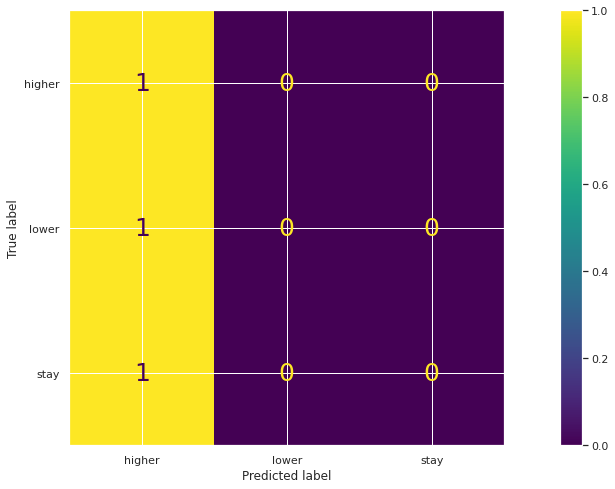

In [8]:
DATA_PATH = './data'
FILE_SUFFIX = '.txt'

quotations = ['GOOG', 'AAPL', 'AMZN']
price_column = 'Close'
THRESH_DIFF = 0.5

for i in range(0, len(quotations)):
    if i == 0:
        df = pipeline_preprocessing(f"{DATA_PATH}/{quotations[i]}{FILE_SUFFIX}", price_column=price_column, thresh_diff=THRESH_DIFF)
    else:
        df = df.append(pipeline_preprocessing(f"{DATA_PATH}/{quotations[i]}{FILE_SUFFIX}", price_column=price_column, thresh_diff=THRESH_DIFF))

    
data_columns = ['Close', 'PercentageDiff', 'MA_diff', 'RSI', 'Next', 'Volume']

clf_dict, dataset_splits = pipeline_ML(df, data_columns=data_columns, use_class_weights=True)
evaluate(clf_dict, dataset_splits, experiment_label=f"on {quot+', ' for quot in quotations}")